In [6]:
cd /home/schlecker/repos/planeteScripts

/home/schlecker/repos/planeteScripts


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import output
import plots
import stats
import utils

%load_ext autoreload
%autoreload 2

# default output folder
outputs = '/home/schlecker/phd/planete/outputs/pop06_MstarGrid/'

pd.set_option('display.max_columns', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read ref_reds into a list of populations

In [8]:
filenames = ['ref_red5e9_0.3Msol.dat', 'ref_red5e9_0.5Msol.dat', 'ref_red5e9_0.7Msol.dat', 'ref_red5e9_1.0Msol.dat'] 
populations = [output.Population(outputs + f, name=f[11:18]) for f in filenames]

In [9]:
populations[1].data

,n,t,mCore,menv,m,L,Lcomp,mdotcore,mdotgasl,rcore,10,pcore,tcore,rhocen,r,15,16,17,a,19,mdiskg,mdiskp,rroche,racc,dt,sigmamean,rfeed,rcaptot,28,tneb,pneb,type_mig,mejetot,macctot,miso,sigmagas,36,37,38,dtpl,40,rhocore,mgazacc,mgazevap,pout,tout,46,47,48,49,50,lcont,enew,ediff,kenergdiff,lacccore,ep,ip,58,59,60,61,e,i,64,65,typemig,status,68,tmig,tmige,71,72,mdotgas,74,75,76,77,dtmode,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,lactual,corrlesti,correesti,103,mdotgasmax,105,106,lcontenv,lcontsum,dust2gas,110,111,112,113,114,115,systemNo,planetNo,isystem,iplanet,isystemorig,iplanetorig,nplanets,line
0,2064.610,5.000000e+09,0.205350,0.000000,0.205350,1.367260e-05,1.367260e-05,0.0,0.000000e+00,0.053130,1.367260e-05,0.000000e+00,114.5070,0.000000,0.053130,1.367260e-05,0.000000,114.5070,1.131910,0.0,0.0,0.0,1.259290e+11,0.0,100000000.0,0.0,0.0,0.0,0.0,114.5070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.34423,0.0,0.0,0.0,0.0,0.0,6.00284,0.036553,6.00284,0.461361,0.000000,-1.563380e+38,0.0,1.258360,1.367260e-05,0.0,0.0,205.546,-1.563360e+38,0.0,0.0,0.0,0.002954,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.367260e-05,0.0,0.000000,0.000000,5.768620e+09,7.0,0.0,0.0,0.00003,0.000000,0.0000,0.0,0.0,0.000000e+00,0.053130,114.5070,0.000000,1.367260e-05,0.205350,0.053130,114.5070,0.666667,0.205350,0.053130,0.0,0.0,1.134300e+36,-1.563360e+38,0.000345,0.248247,0.999812,0.0,0.0,0.0,0.0,0.0,25.8311,0.016184,75.8972,0.9,18.3264,1.202070,5.221390e-10,0.000000,0.242164,0.0,1,1,1,1,1,CD_00000000000000_SIM00000000000001/tracks_001...
1,1210.180,5.000000e+09,0.012486,0.000000,0.012486,3.788620e-07,3.788620e-07,0.0,0.000000e+00,0.026971,3.788620e-07,0.000000e+00,26.5395,0.000000,0.026971,3.788620e-07,0.000000,26.5395,21.071300,0.0,0.0,0.0,9.218130e+11,0.0,100000000.0,0.0,0.0,0.0,0.0,26.5395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.48386,0.0,0.0,0.0,0.0,0.0,0.00000,0.036553,0.00000,0.461361,0.000000,0.000000e+00,0.0,0.000000,3.788620e-07,0.0,0.0,0.000,0.000000e+00,0.0,0.0,0.0,-0.009955,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.788620e-07,0.0,0.000000,0.000000,0.000000e+00,6.0,0.0,0.0,0.00003,0.000000,0.0000,0.0,0.0,0.000000e+00,0.026971,26.5395,0.000000,3.788620e-07,0.012486,0.026971,26.5395,0.666667,0.012486,0.026971,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,14.7919,0.027186,79.6852,0.9,20.2014,21.086000,3.641000e-10,0.536364,0.255020,0.0,2,1,2,1,1,CD_00000000000000_SIM00000000000002/tracks_001...
2,1443.160,5.000000e+09,0.349522,0.000000,0.349522,2.049230e-05,2.049230e-05,0.0,0.000000e+00,0.061804,2.049230e-05,0.000000e+00,549.0070,0.000000,0.061804,2.049230e-05,0.000000,549.0070,0.049240,0.0,0.0,0.0,6.540740e+09,0.0,100000000.0,0.0,0.0,0.0,0.0,549.0070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.77884,0.0,0.0,0.0,0.0,0.0,0.00000,0.036553,0.00000,0.461361,0.000000,0.000000e+00,0.0,0.000000,2.049230e-05,0.0,0.0,0.000,0.000000e+00,0.0,0.0,0.0,-0.002437,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.049230e-05,0.0,0.000000,0.000000,0.000000e+00,7.0,0.0,0.0,0.00003,0.000000,0.0000,0.0,0.0,0.000000e+00,0.061804,549.0070,0.000000,2.049230e-05,0.349522,0.061804,549.0070,0.666667,0.349522,0.061804,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,26.4999,0.012100,109.4660,0.9,38.1225,0.098435,1.491570e-09,0.000000,0.332625,0.0,3,1,3,1,1,CD_00000000000000_SIM00000000000003/tracks_001...
3,2321.570,5.000000e+09,2.513270,0.000000,2.513270,1.472520e-04,1.472520e-04,0.0,0.000000e+00,0.112294,1.472520e-04,0.000000e+00,435.6120,0.000000,0.112294,1.472520e-04,0.000000,435.6120,0.078212,0.0,0.0,0.0,2.005260e+10,0.0,100000000.0,0.0,0.0,0.0,0.0,435.6120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.92767,0.0,0.0,0.0,0.0,0.0,7.35914,0.036553,7.35914,0.461361,0.000000,-1.104480e+40,0.0,1.279010,1.472520e-04,0.0,0.0,2057.920,-1.104470e+40,0.0,0.0,0.0,0.002019,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.472520e-04,0.0,0.000000,0.000000,2.423670e+09,7.0,0.0,0.0,0.00003,0.000000,0.0000,0.0,0.0,0.000000e+00,0.112294,435.6

concatenate population data into a single multiindex-dataframe

In [10]:
jointdf = pd.concat([pop.data for pop in populations], axis=0, keys=[pop.name for pop in populations])

In [11]:
jointdf

n             t      mCore         menv            m  \
0.3Msol 0      1189.180  5.000000e+09   0.184648     0.000000     0.184648   
        1      2766.750  5.000000e+09   0.675386     0.014123     0.689509   
        2      1111.180  5.000000e+09   0.013418     0.000000     0.013418   
        3      1138.180  5.000000e+09   0.020679     0.000000     0.020679   
        4       829.179  5.000000e+09   0.032685     0.000000     0.032685   
        5       477.173  5.000000e+09   0.025720     0.000000     0.025720   
        6      9156.150  5.000000e+09  17.373700     0.000000    17.373700   
        7      7713.070  5.000000e+09  16.774800     0.000000    16.774800   
        8      1644.290  5.000000e+09   1.473720     0.000000     1.473720   
        9      1579.540  5.000000e+09   1.504180     0.000000     1.504180   
        10     2035.170  5.000000e+09   0.906857     0.000000     0.906857   
        11    11699.100  5.000000e+09  13.251900     0.000000    13.251900   
        12     1042.180  5.000000e+09   0.064183     0.000000     0.064183   
        13     1356.170  5.000000e+09   0.085542     0.000000     0.085542   
        14     2199.140  5.000000e+09   0.730400     0.000000     0.730400   
        15     1350.170  5.000000e+09   0.017177     0.000000     0.017177   
        16      766.177  5.000000e+09   0.033122     0.000000     0.033122   
        17      721.175  5.000000e+09   0.013980     0.000000     0.013980   
        18     2043.410  5.000000e+09   1.921160     0.000000     1.921160   
        19      846.177  5.000000e+09   0.047780     0.000000     0.047780   
        20     6191.470  5.000000e+09   8.865860     0.000000     8.865860   
        21      588.176  5.000000e+09   0.061669     0.000000     0.061669   
        22     3119.870  5.000000e+09   0.240991     0.000023     0.241014   
        23      648.178  5.000000e+09   0.064229     0.000000     0.064229   
        24      970.179  5.000000e+09   0.028989     0.000000     0.028989   
        25     1662.990  5.000000e+09   0.968529     0.004016     0.972545   
        26     2543.140  5.000000e+09   0.698700     0.000000     0.698700   
        27     4958.920  5.000000e+09  19.585700     0.000000    19.585700   
        28     1785.540  5.000000e+09   1.445190     0.000000     1.445190   
        29     1013.180  5.000000e+09   0.200781     0.000000     0.200781   
...                 ...           ...        ...          ...          ...   
1.0Msol 9939    987.178  5.000000e+09   0.027414     0.000000     0.027414   
        9940   1101.180  5.000000e+09   0.015770     0.000000     0.015770   
        9941   3461.070  5.000000e+09  36.131900   855.837000   891.969000   
        9942  10251.500  5.000000e+09  23.141800     7.612650    30.754400   
        9943   2951.050  5.000000e+09   6.503880     1.090300     7.594170   
        9944   2097.100  5.000000e+09   0.541607     0.000000     0.541607   
        9945   1713.130  5.000000e+09   0.140722     0.000000     0.140722   
        9946   2773.570  5.000000e+09  12.253000     2.275770    14.528800   
        9947  17004.400  5.000000e+09  13.070600     0.000000    13.070600   
        9948   5403.480  5.000000e+09  40.667300  1551.890000  1592.560000   
        9949   4022.030  5.000000e+09  31.779200  1703.850000  1735.630000   
        9950   4163.790  5.000000e+09   4.631390     0.254565     4.885960   
        9951   3155.230  5.000000e+09   0.316923     0.000042     0.316965   
        9952   8199.750  5.000000e+09  20.462200    46.792900    67.255000   
        9953  24237.500  5.000000e+09  27.646200     0.119079    27.765300   
        9954  11560.700  5.000000e+09  12.522300     1.195740    13.718100   
        9955   1442.180  5.000000e+09   0.406143     0.000000     0.406143   
        9956   2506.430  5.000000e+09   3.887990     0.339892     4.227880   
        9957   3757.040  5.000000e+09   0.949826     0.000000     0.949826   
        9958   1643.540  5.000000e+09   0.82

not yet sure what to do with this... lets get some stats

In [12]:
stats = {p.name : p.get_typeStats() for p in populations}

In [13]:
stats['0.5Msol']

,Earth,SuperEarth,all,ltEarth
Nplanets,1499.000000,1990.000000,9999.000000,4565.000000
Nsystems,1499.000000,1990.000000,9999.000000,4565.000000
fractionSystems,0.149915,0.199020,1.000000,0.456546
meanEccentricity,0.000000,0.000000,0.000000,0.000000
meanMetallicity,-0.013421,-0.003380,-0.023330,0.028433
multiplicity,1.000000,1.000000,1.000000,1.000000
occurrence,0.149915,0.199020,1.000000,0.456546
stdEccentricity,0.000000,0.000000,0.000000,0.000000
stdMetallicity,0.211481,0.215307,0.218326,0.213449


In [14]:
for planetType in stats['0.5Msol']:
    print(planetType)

Earth
SuperEarth
all
ltEarth


how about a summary plot?

In [15]:
def plot_typeStats(populations):
    """
    
    """
    if isinstance(populations, list):
        stats = {p.name : p.get_typeStats() for p in populations}
        fig, ax = plt.subplots()
        stellarMasses = [0.3, 0.5, 0.7, 1.0]
        for M, Mstar in enumerate(stats.keys()):
            for planetType in stats[Mstar]:
                plt.errorbar(stellarMasses[M], stats[Mstar][planetType]['meanMetallicity'], stats[Mstar][planetType]['stdMetallicity'],
                             capsize=40., fmt='o', label=planetType)
        plt.legend()

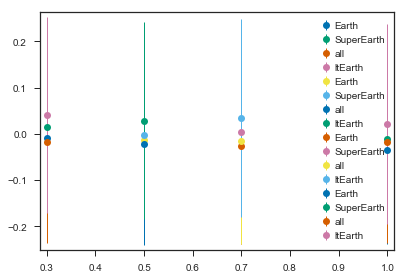

In [16]:
plot_typeStats(populations)

wow, this was rough. let's try something else

In [12]:
for Mstar, MPop in jointdf.groupby(level=0):

SyntaxError: unexpected EOF while parsing (<ipython-input-12-6d39a49bf851>, line 1)

In [13]:
sns.catplot(x='Mstar', y='Metallicity', kind='bar', data=jointdf)

AttributeError: module 'seaborn' has no attribute 'catplot'